In [1]:
options(repr.plot.width=15, repr.plot.height=7)

In [ ]:
## Load the Libraries #####
# install.packages(c("osmdata", "magrittr", "dplyr","ggmap", "lubridate","leaflet", "worldcloud","RcolorBrewer","plotly","tidyverse","sf","tmap"))

library(lubridate)
library(ggmap)
library(leaflet)
# library(wordcloud)
library(RColorBrewer)
library(plotly)
library(tidyverse)
library(sf)
library(tmap)
library(osmdata)

Warning message:
"package 'lubridate' was built under R version 4.4.3"

Attaching package: 'lubridate'


The following objects are masked from 'package:base':

    date, intersect, setdiff, union


Warning message:
"package 'ggmap' was built under R version 4.4.3"
Loading required package: ggplot2

Warning message:
"package 'ggplot2' was built under R version 4.4.2"
ℹ Google's Terms of Service: <https://mapsplatform.google.com>
  Stadia Maps' Terms of Service: <https://stadiamaps.com/terms-of-service>
  OpenStreetMap's Tile Usage Policy: <https://operations.osmfoundation.org/policies/tiles>
ℹ Please cite ggmap if you use it! Use `citation("ggmap")` for details.
Warning message:
"package 'leaflet' was built under R version 4.4.3"
Warning message:
"package 'plotly' was built under R version 4.4.3"

Attaching package: 'plotly'


The following object is masked from 'package:ggmap':

    wind


The following object is masked from 'package:ggplot2':

    last_plot


The following object is m

: 

In [3]:
NYC_Collisions = read.csv("NYC_Collisions.csv")
# attach(NYC_Collisions)
df = NYC_Collisions

## View the dataset #####
head(NYC_Collisions)

,Collision.ID,Date,Time,Borough,Street.Name,Cross.Street,Latitude,Longitude,Contributing.Factor,Vehicle.Type,Persons.Injured,Persons.Killed,Pedestrians.Injured,Pedestrians.Killed,Cyclists.Injured,Cyclists.Killed,Motorists.Injured,Motorists.Killed
,<int>,<chr>,<chr>,<chr>,<chr>,<chr>,<dbl>,<dbl>,<chr>,<chr>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>
1,4491746,2021-01-01,20:00:00,Bronx,Bruckner Expressway,,40.83398,-73.82635,Pavement Slippery,Passenger Vehicle,0,0,0,0,0,0,0,0
2,4441905,2021-01-01,05:28:00,Brooklyn,Lafayette Avenue,,40.68730,-73.97366,Unspecified,Passenger Vehicle,0,0,0,0,0,0,0,0
3,4382769,2021-01-01,06:00:00,Staten Island,West Shore Expressway,,NA,NA,Fell Asleep,Passenger Vehicle,0,0,0,0,0,0,0,0
4,4380949,2021-01-01,19:30:00,Bronx,Sedgwick Avenue,Vancortlandt Avenue West,40.88270,-73.89273,,Not Reported,0,0,0,0,0,0,0,0
5,4380940,2021-01-01,07:40:00,Brooklyn,Cortelyou Road,Mc Donald Avenue,40.63791,-73.97864,Unspecified,Passenger Vehicle,0,0,0,0,0,0,0,0
6,4380963,2021-01-01,18:45:00,Manhattan,Harlem River Drive,,40.84863,-73.92762,Pedestrian/Bicyclist/Other Pedestrian Error/Confusion,Passenger Vehicle,0,0,0,0,0,0,0,0


In [4]:
# colnames(NYC_Collisions)
# summary(NYC_Collisions)

In [4]:
## Time Series Analysis ####
### Distributions of the accidents vs time ######
#### Convert Date and Time Column to relavent format ####
df$Data = as.Date(df$Date, format("%Y-%m-%d"))
df$Time = hms::as_hms(df$Time)

#### Extract the relavent Content from the data ####
df$Year = year(df$Date)
df$Month = month(df$Date)
df$Date = date(df$Date)
df$Day_Of_Week = wday(df$Date, label = TRUE)
df$Hour = hour(df$Time)

# Extract month as a number (1 to 12)
df$Month = month(df$Date)

# Convert month number to ordered factor with month names
df$Month = factor(df$Month, 
                  levels = 1:12, 
                  labels = c("January", "February", "March", "April", 
                             "May", "June", "July", "August", 
                             "September", "October", "November", "December"),
                  ordered = TRUE)

df$Fatal <- ifelse(df$Persons.Killed > 0, TRUE, FALSE)
df$Injured <- ifelse(df$Persons.Injured > 0, TRUE, FALSE)
df$InjuredKilled <- ifelse(df$Fatal & df$Injured, TRUE, FALSE)

In [5]:
nrow(df[df$InjuredKilled==FALSE,])

[1] 238267

In [160]:
df |> filter(Fatal == TRUE) |> group_by(Year) |> summarise(Total = sum(Fatal)) |> select("Total")

Total
<int>
284
275
54


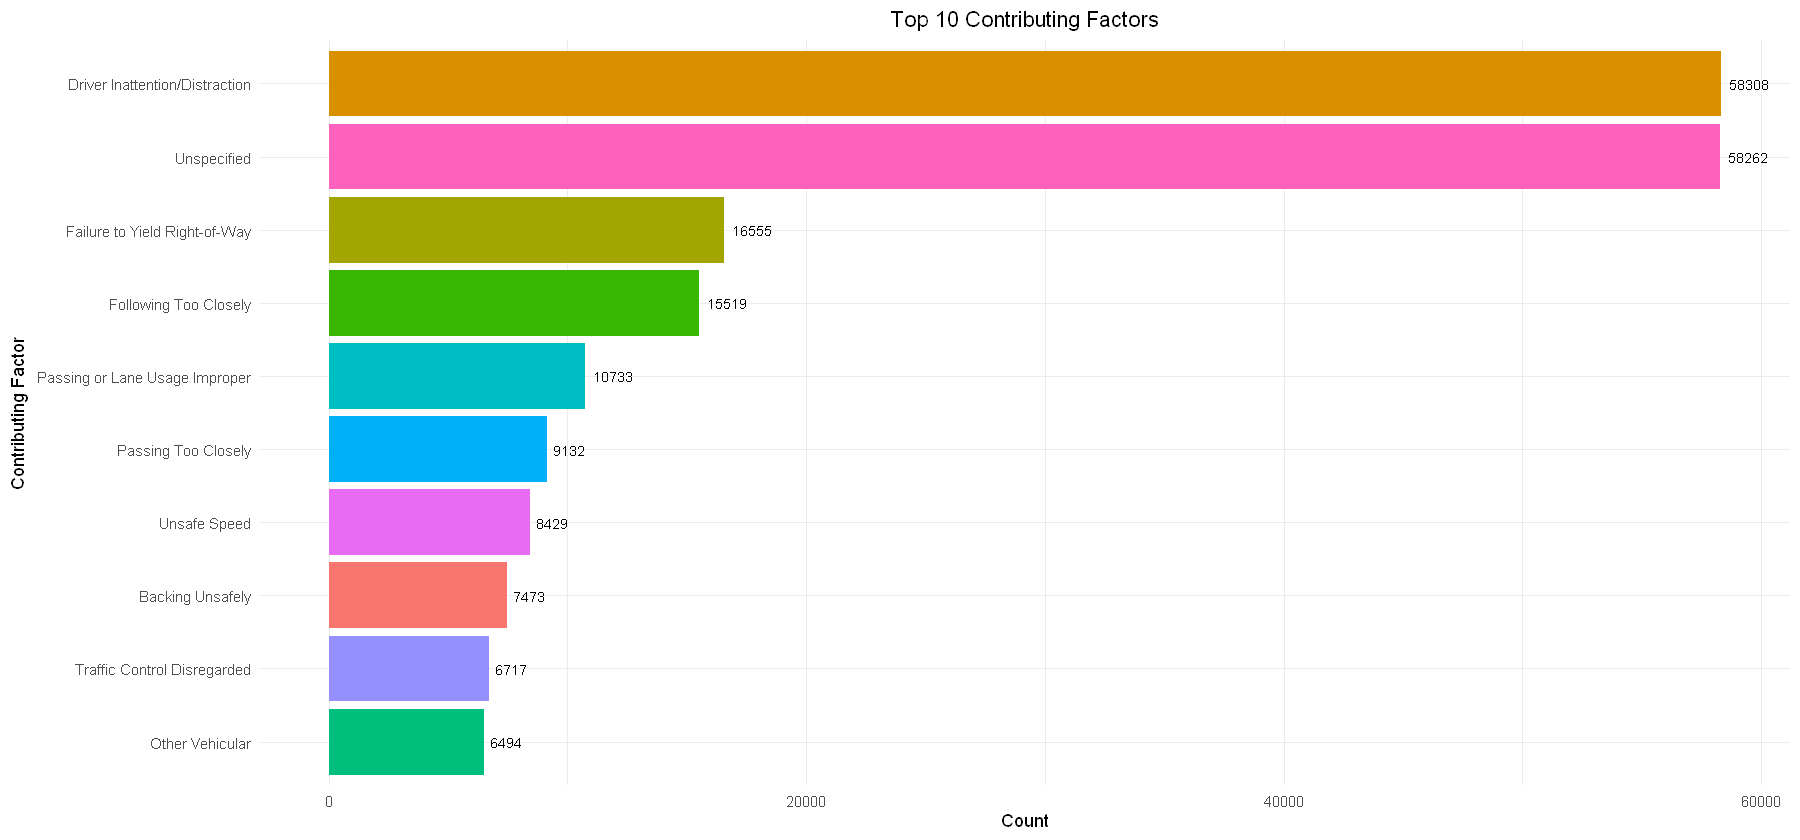

In [273]:
top_contributing_factors <- df |> count(Contributing.Factor) |> arrange(desc(n)) |> head(10)

ggplot(top_contributing_factors, aes(x = reorder(Contributing.Factor, n), y = n, fill = Contributing.Factor)) +
    geom_bar(stat = "identity") +
    geom_text(aes(label = n), hjust = -0.2, size = 3) +
    coord_flip() +
    labs(title = "Top 10 Contributing Factors",
         x = "Contributing Factor",
         y = "Count") +
    theme_minimal() +
    theme(plot.title = element_text(hjust = 0.5)) +
    guides(fill = "none")

In [ ]:
df_2021=df[df$Year==2021,]
df_2022=df[df$Year==2022,]
df_2023=df[df$Year==2023,]
# paste("Start:",df_2021[1,]$Date, "End:", tail(df_2023, 1)$Date)

# df |> count(Year) |> select(n)

sum_table <- data.frame(
    Year = c(2021, 2022, 2023),
    Count = df |> count(Year) |> select(n) |> rename(Count = n),
    Fatalities = df |> group_by(Year) |> summarise(Fatalities = sum(Fatal)) |> pull(Fatalities),
    Killed = df |> group_by(Year) |> summarise(Killed = sum(Persons.Killed)) |> pull(Killed),
    Injured = df |> group_by(Year) |> summarise(Injured = sum(Injured==TRUE, na.rm = TRUE)) |> pull(Injured)
)
sum_table

Year,Count,Fatalities,Killed,Injured
<dbl>,<int>,<int>,<int>,<int>
2021,110546,284,294,38588
2022,103780,275,285,39104
2023,24095,54,56,9410


In [7]:
nrow(df_2021[df_2021$Injured==TRUE,])

[1] 38589

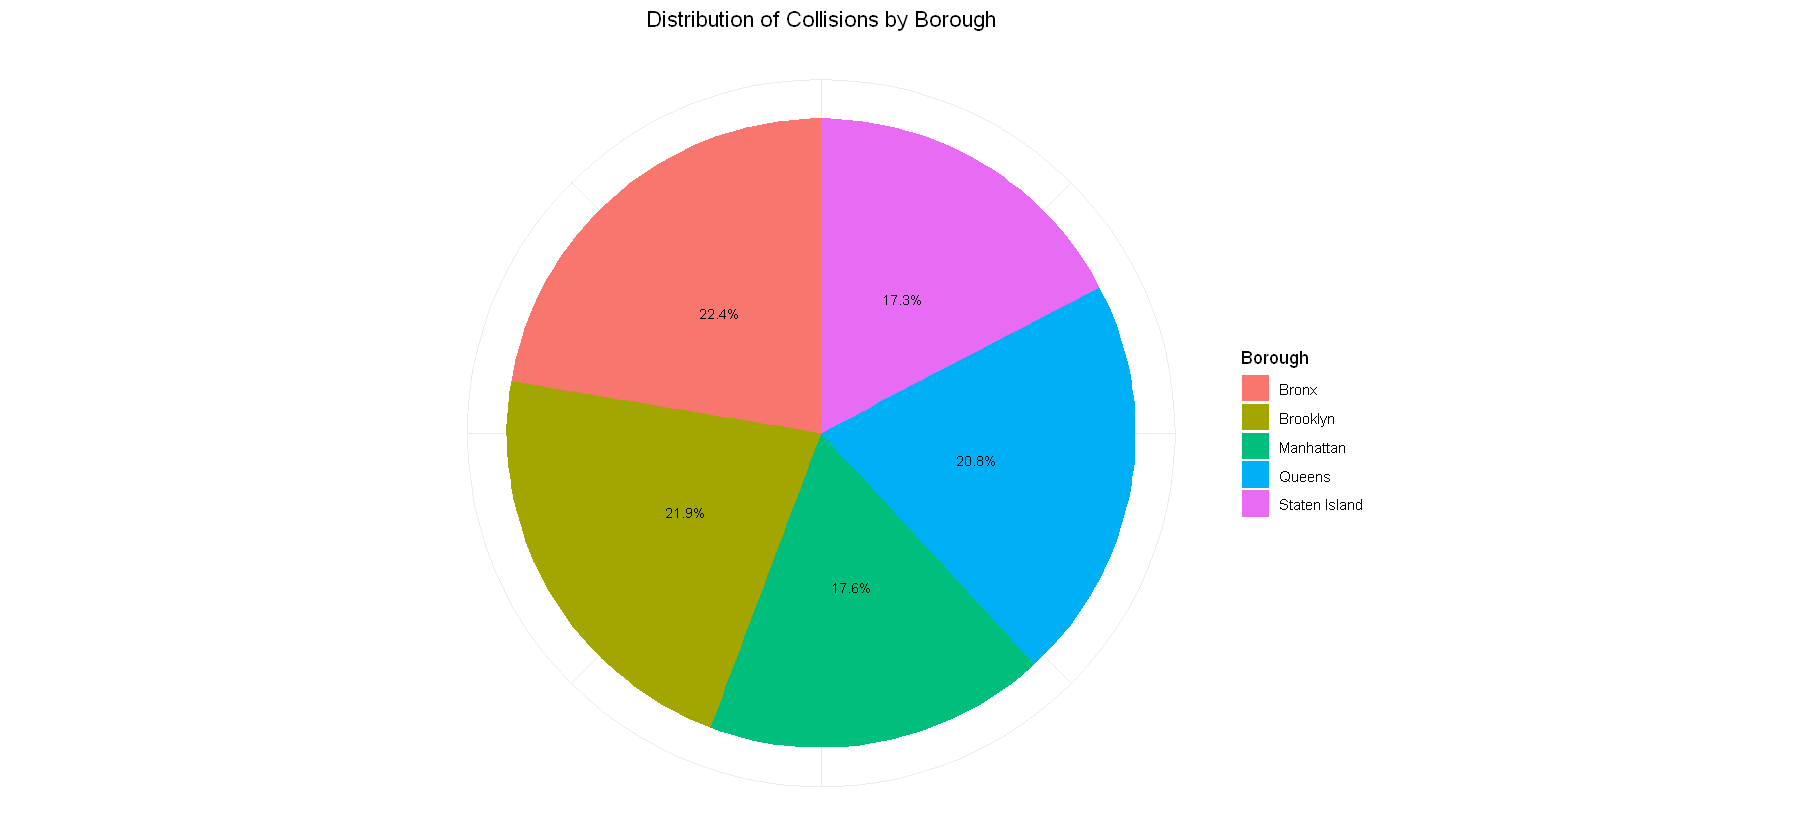

In [83]:
borough_counts <- df |> count(Borough)
# https://www.nyc.gov/assets/planning/download/pdf/planning-level/nyc-population/population-estimates/current-population-estimates-2023-June2024-release.pdf
borough_counts <- borough_counts[-1, ]
borough_counts["population"] <- c(1356476, 2561225, 1597451, 2252196, 490687) 
borough_counts <- borough_counts |> mutate(Collisions_Per_Capita = n / population)
# sum(borough_counts["population"])
# borough_counts

borough_counts <- borough_counts |> 
    mutate(Percentage = Collisions_Per_Capita / sum(Collisions_Per_Capita) * 100)
# borough_counts

ggplot(borough_counts, aes(x = "", y = Percentage, fill = Borough)) +
    geom_bar(stat = "identity", width = 1) +
    coord_polar("y", start = 0) +
    labs(title = "Distribution of Collisions by Borough",
         x = NULL,
         y = NULL,
         fill = "Borough") +
    theme_minimal() +
    theme(axis.text = element_blank(),
          axis.ticks = element_blank(),
          plot.title = element_text(hjust = 0.5)) +
    geom_text(aes(label = paste0(round(Percentage, 1), "%")), 
              position = position_stack(vjust = 0.5), size = 3)

In [308]:
df |> filter(Fatal == TRUE) |> count(Vehicle.Type) |> arrange(desc(n)) |> head(10)

,Vehicle.Type,n
,<chr>,<int>
1,Passenger Vehicle,394
2,Motorcycle,60
3,Transport,35
4,Bicycle,32
5,Not Reported,19
6,Scooter,19
7,Bus,16
8,Utility Vehicle,9
9,Taxi,8


In [311]:
colnames(df)

[1] "Collision.ID"        "Date"                "Time"               
 [4] "Borough"             "Street.Name"         "Cross.Street"       
 [7] "Latitude"            "Longitude"           "Contributing.Factor"
[10] "Vehicle.Type"        "Persons.Injured"     "Persons.Killed"     
[13] "Pedestrians.Injured" "Pedestrians.Killed"  "Cyclists.Injured"   
[16] "Cyclists.Killed"     "Motorists.Injured"   "Motorists.Killed"   
[19] "Data"                "Year"                "Month"              
[22] "Day_Of_Week"         "Hour"                "Fatal"

In [357]:
# Define the vehicle types to analyze
vehicle_types <- c("Passenger Vehicle", "Motorcycle", "Transport", "Bicycle", "Bus")

# Initialize an empty data frame to store the results
killed_summary <- data.frame()

# Loop through each vehicle type and calculate the summary
for (vehicle_type in vehicle_types) {
    df_vehicle <- df[df$Vehicle.Type == vehicle_type, ]
    total_injuries <- data.frame(
        Vehicle_Type = vehicle_type,
        Deceased = c("Motorist", "Pedestrian", "Cyclist"),
        Deaths = c(sum(df_vehicle$Motorists.Killed), sum(df_vehicle$Pedestrians.Killed), sum(df_vehicle$Cyclists.Killed))
    )
    killed_summary <- rbind(killed_summary, total_injuries)
}

# Display the combined summary
killed_summary


Vehicle_Type,Deceased,Deaths
<chr>,<chr>,<int>
Passenger Vehicle,Motorist,174
Passenger Vehicle,Pedestrian,202
Passenger Vehicle,Cyclist,19
Motorcycle,Motorist,59
Motorcycle,Pedestrian,3
Motorcycle,Cyclist,0
Transport,Motorist,6
Transport,Pedestrian,19
Transport,Cyclist,7


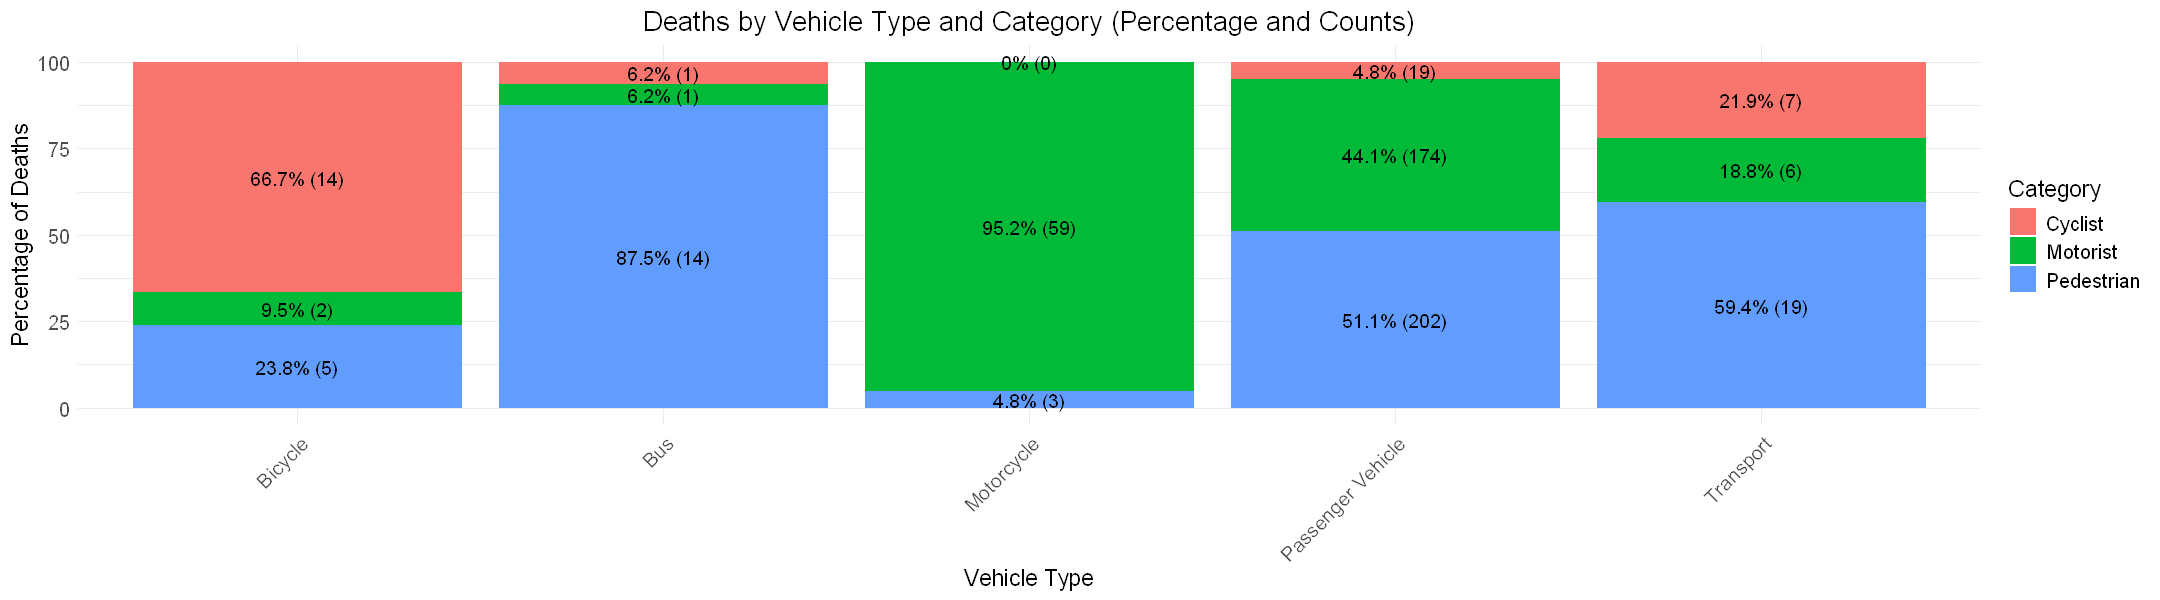

In [407]:
options(repr.plot.width=18, repr.plot.height=5)

# Calculate percentages
killed_summary <- killed_summary |> 
     group_by(Vehicle_Type) |> 
     mutate(Percentage = Deaths / sum(Deaths) * 100)

# Plot as stacked percentages with counts
ggplot(killed_summary, aes(x = Vehicle_Type, y = Percentage, fill = Deceased)) +
     geom_bar(stat = "identity", position = "stack") +
     geom_text(aes(label = paste0(round(Percentage, 1), "% (", Deaths, ")")), 
                 position = position_stack(vjust = 0.5), size = 4) + 
     labs(title = "Deaths by Vehicle Type and Category (Percentage and Counts)",
           x = "Vehicle Type",
           y = "Percentage of Deaths",
           fill = "Category") +
     theme_minimal() +
     theme(plot.title = element_text(hjust = 0.5, size = 16),  
            axis.text.x = element_text(angle = 45, hjust = 1, size = 12),  
            axis.text.y = element_text(size = 12), 
            axis.title = element_text(size = 14), 
            legend.text = element_text(size = 12),  
            legend.title = element_text(size = 14)) 

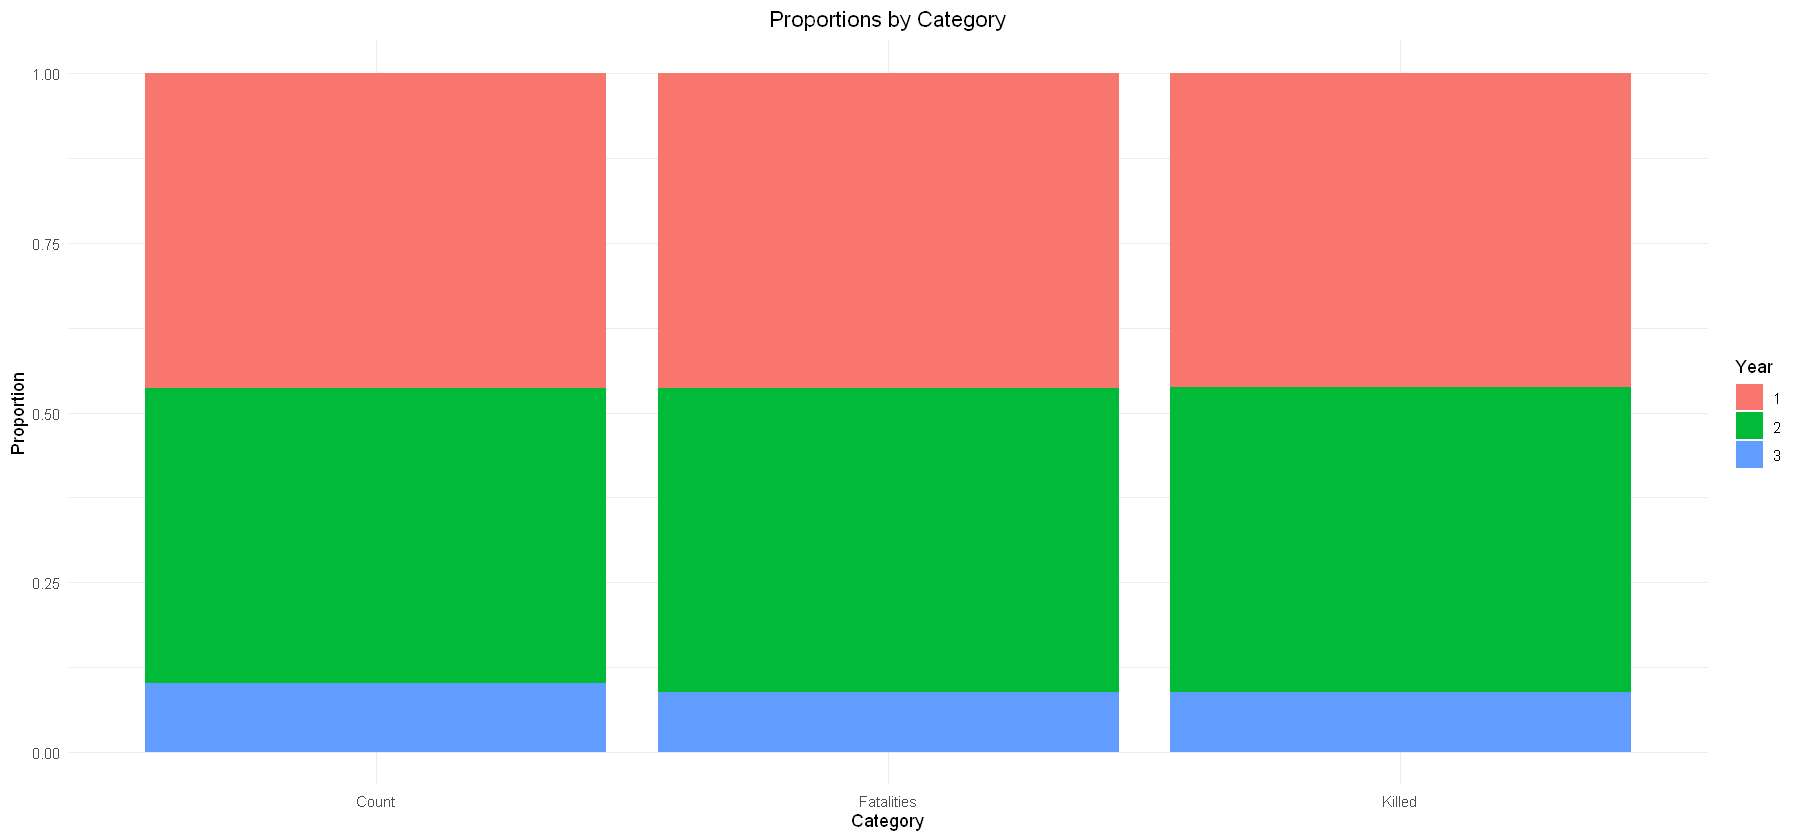

In [269]:
# Reshape the data for plotting
proportions_long <- proportions_df |>
    rownames_to_column(var = "Year") |>
    pivot_longer(cols = -Year, names_to = "Category", values_to = "Proportion")

# Plot the stacked bar chart
ggplot(proportions_long, aes(x = Category, y = Proportion, fill = Year)) +
    geom_bar(stat = "identity") +
    labs(title = "Proportions by Category",
             x = "Category",
             y = "Proportion",
             fill = "Year") +
    theme_minimal() +
    theme(plot.title = element_text(hjust = 0.5))

In [72]:
total_persons_killed_2021 <- df_2021 |> summarise(Total_Killed = sum(Persons.Killed)) |> pull(Total_Killed)
total_persons_killed_2021

[1] 294

In [115]:
sum(df_2021$Fatal)

[1] 284

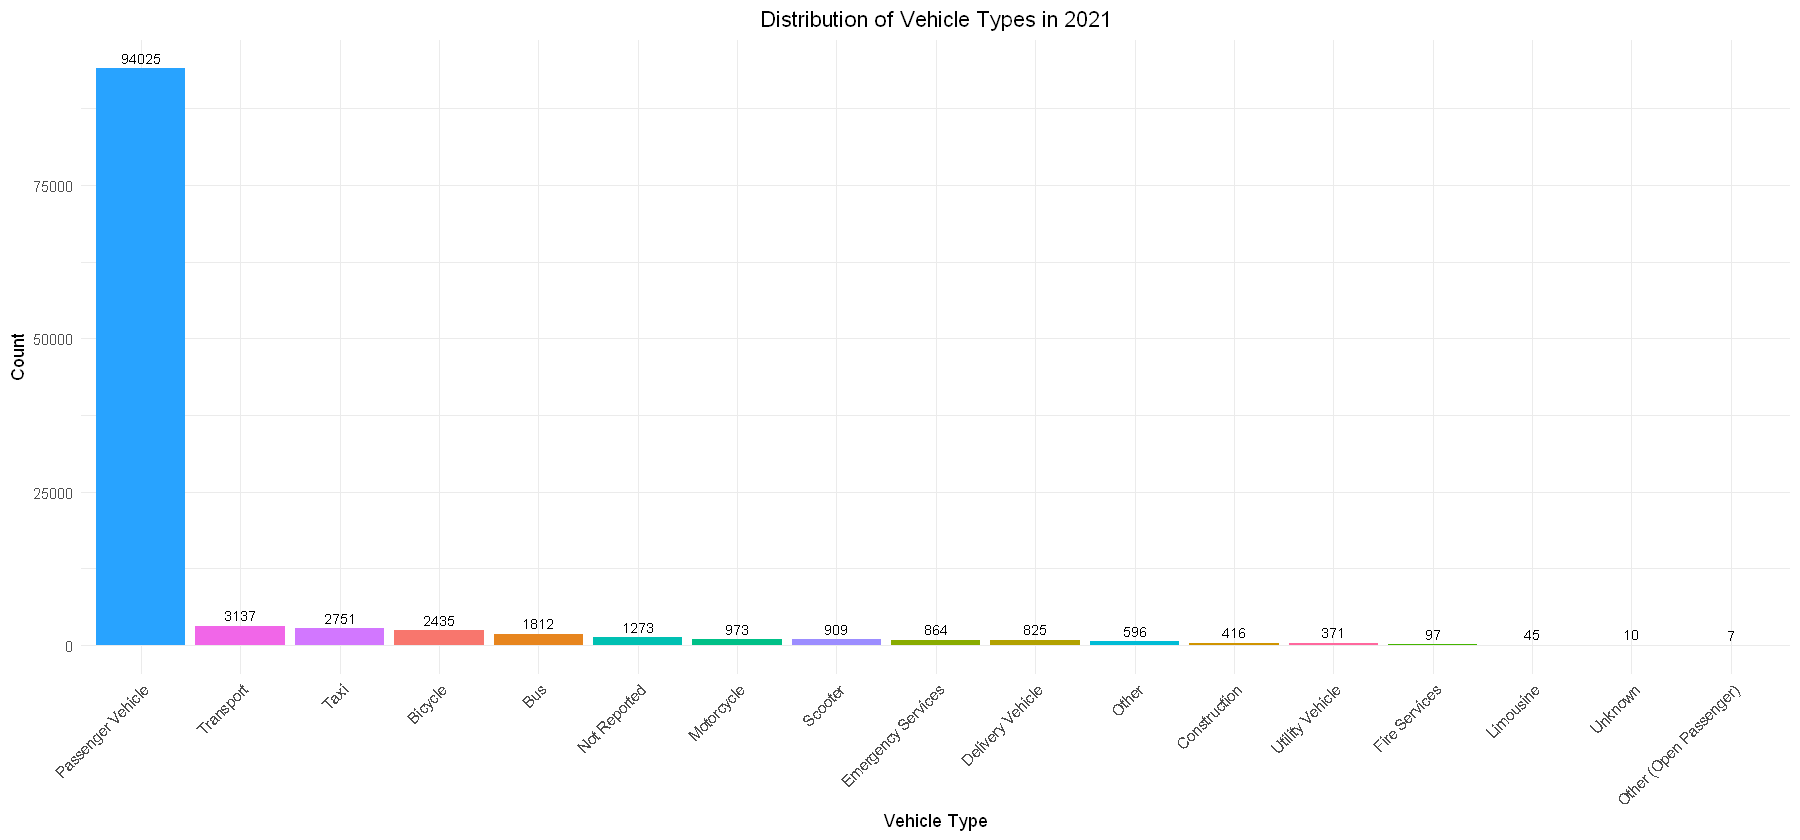

In [188]:
vehicle_type_distribution <- df_2021 |> count(Vehicle.Type) |> arrange(desc(n))

ggplot(vehicle_type_distribution, aes(x = reorder(Vehicle.Type, -n), y = n, fill = Vehicle.Type)) +
    geom_bar(stat = "identity") +
    geom_text(aes(label = n), vjust = -0.5, size = 3) +
    labs(title = "Distribution of Vehicle Types in 2021",
         x = "Vehicle Type",
         y = "Count") +
    theme_minimal() +
    theme(plot.title = element_text(hjust = 0.5),
          axis.text.x = element_text(angle = 45, hjust = 1)) +
    guides(fill = "none")

In [123]:
fatalities_by_year <- data.frame(
    Year = c(2021, 2022),
    Fatalities=c(
        sum(df_2021$Fatal),
        sum(df_2022$Fatal)
    ),
    Killed = c(
        sum(df_2021$Persons.Killed),
        sum(df_2022$Persons.Killed)
    )
)

fatalities_by_year

Year,Fatalities,Killed
<dbl>,<int>,<int>
2021,284,294
2022,275,285


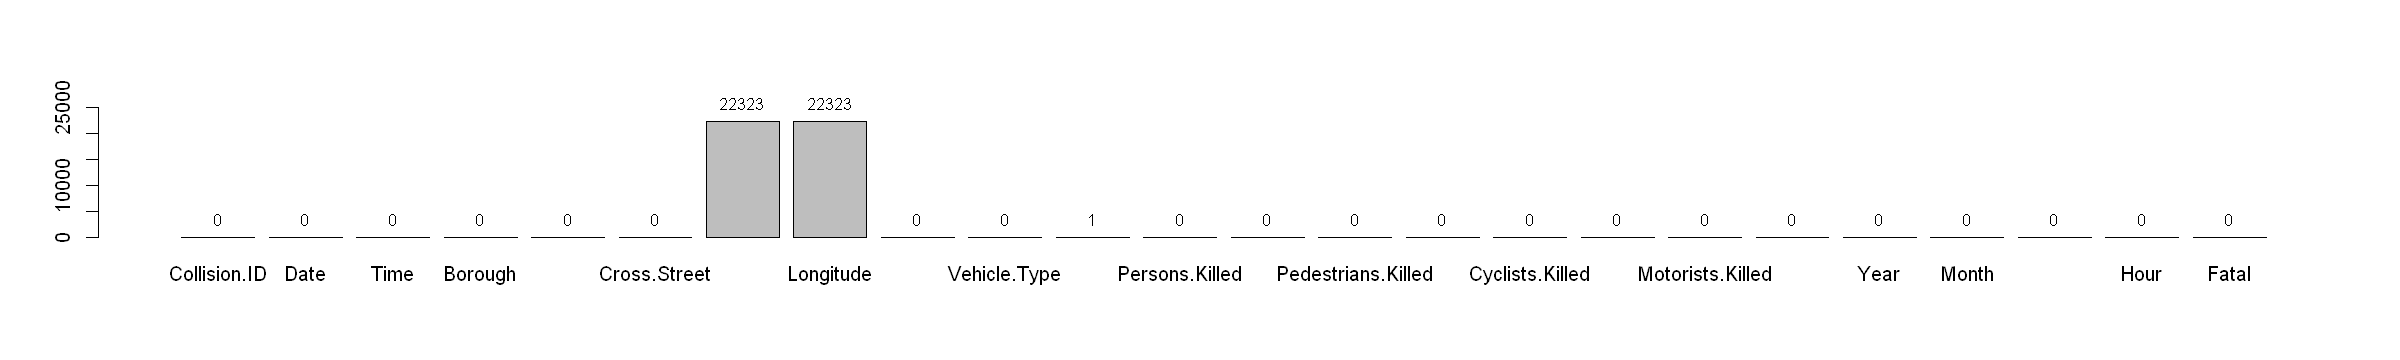

In [304]:
par(bg="white")
options(repr.plot.width=20, repr.plot.height=3)

# Check for null data in each column
null_data_summary <- colSums(is.na(df))
# Display the summary of null data
barplot_heights <- barplot(null_data_summary,  ylim = c(0, max(null_data_summary) * 1.2))  # Increase ylim for text
# Add numbers on top of the bars
text(barplot_heights, null_data_summary, labels = null_data_summary, pos = 3, cex = 0.8)

In [16]:
options(repr.plot.width=20, repr.plot.height=7)

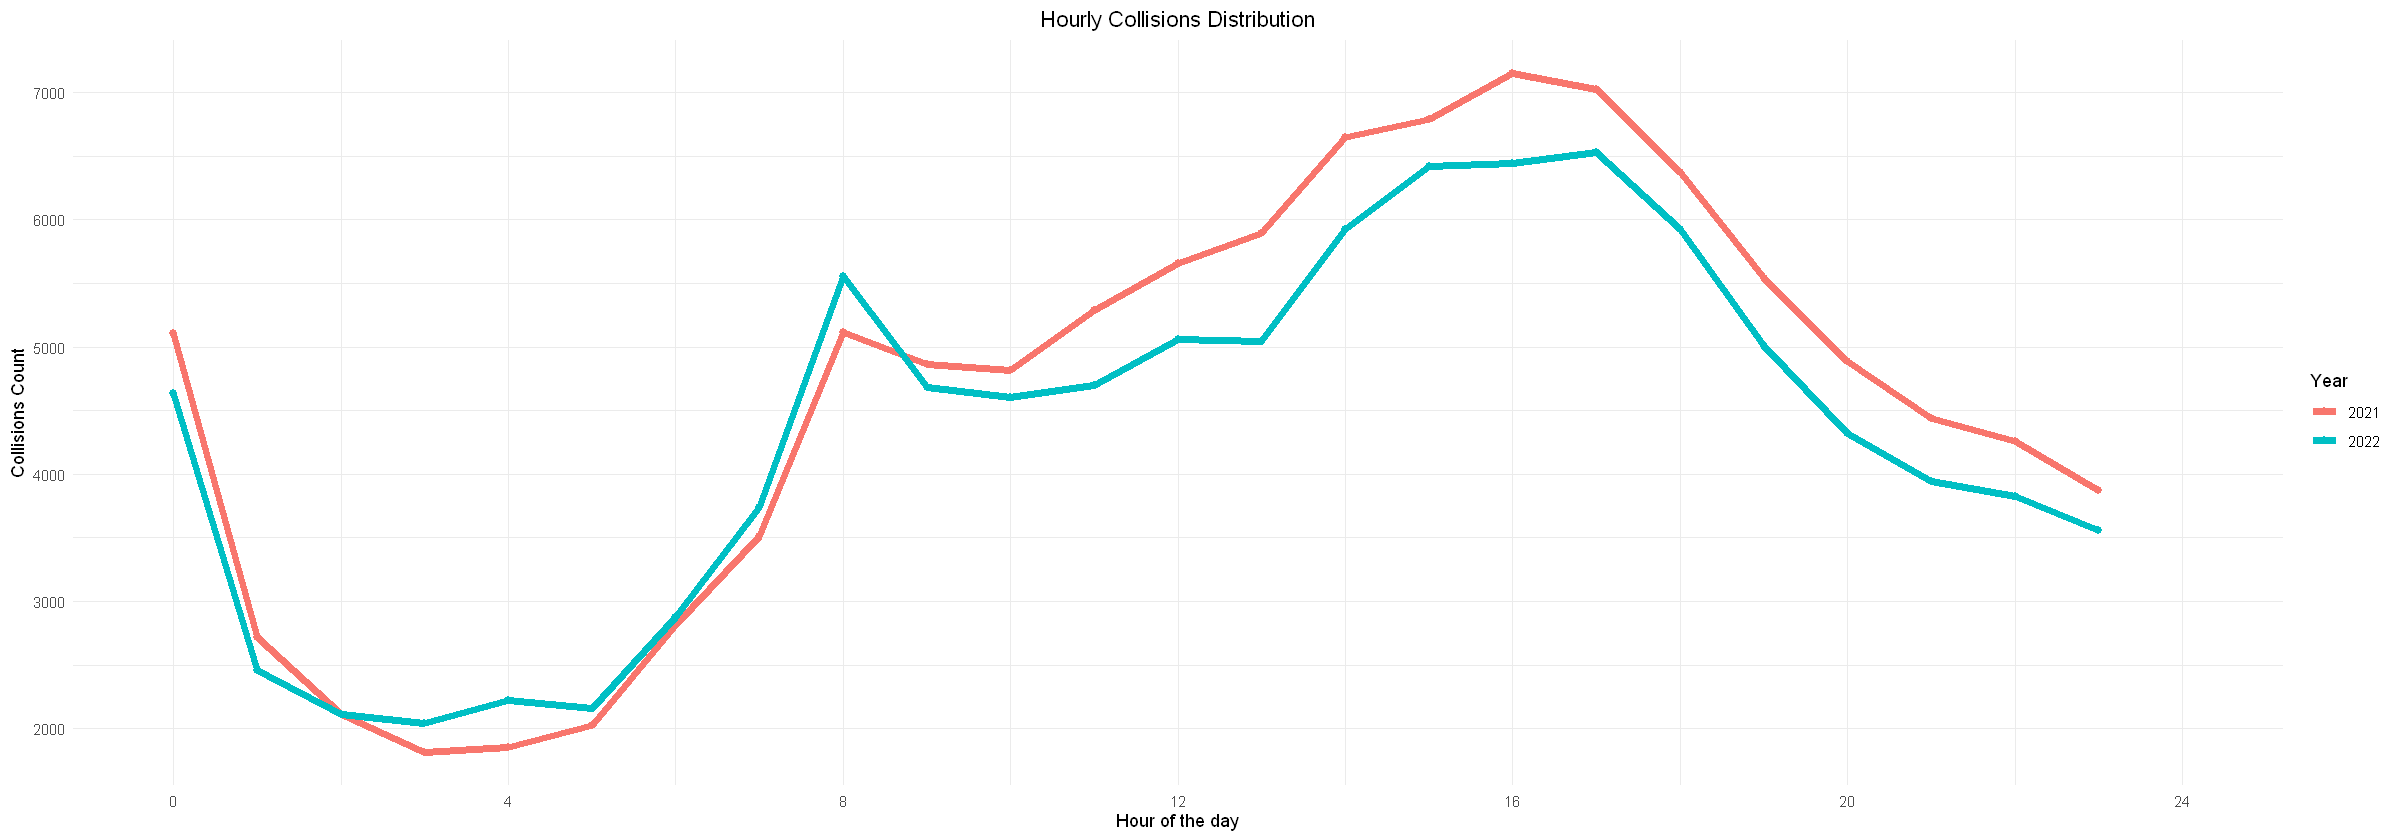

In [20]:
ggplot() +
      geom_line(data = df_2021 |> count(Hour), aes(x = Hour, y = n, color = "2021"), linewidth = 2) +
      geom_point(data = df_2021 |> count(Hour), aes(x = Hour, y = n, color = "2021"), size = 2) +
      geom_line(data = df_2022 |> count(Hour), aes(x = Hour, y = n, color = "2022"), linewidth = 2) +
      geom_point(data = df_2022 |> count(Hour), aes(x = Hour, y = n, color = "2022"), size = 2) +
      # geom_line(data = df_2023 |> count(Hour), aes(x = Hour, y = n, color = "2023"), linewidth = 2) +
      # geom_point(data = df_2023 |> count(Hour), aes(x = Hour, y = n, color = "2023"), size = 2) +
      labs(title = "Hourly Collisions Distribution",
                   x = "Hour of the day",
                   y = "Collisions Count",
                   color = "Year") +
      scale_x_continuous(breaks = seq(0, 24, by = 4), limits = c(0, 24)) +
      theme_minimal() +
      theme(plot.title = element_text(hjust = 0.5))

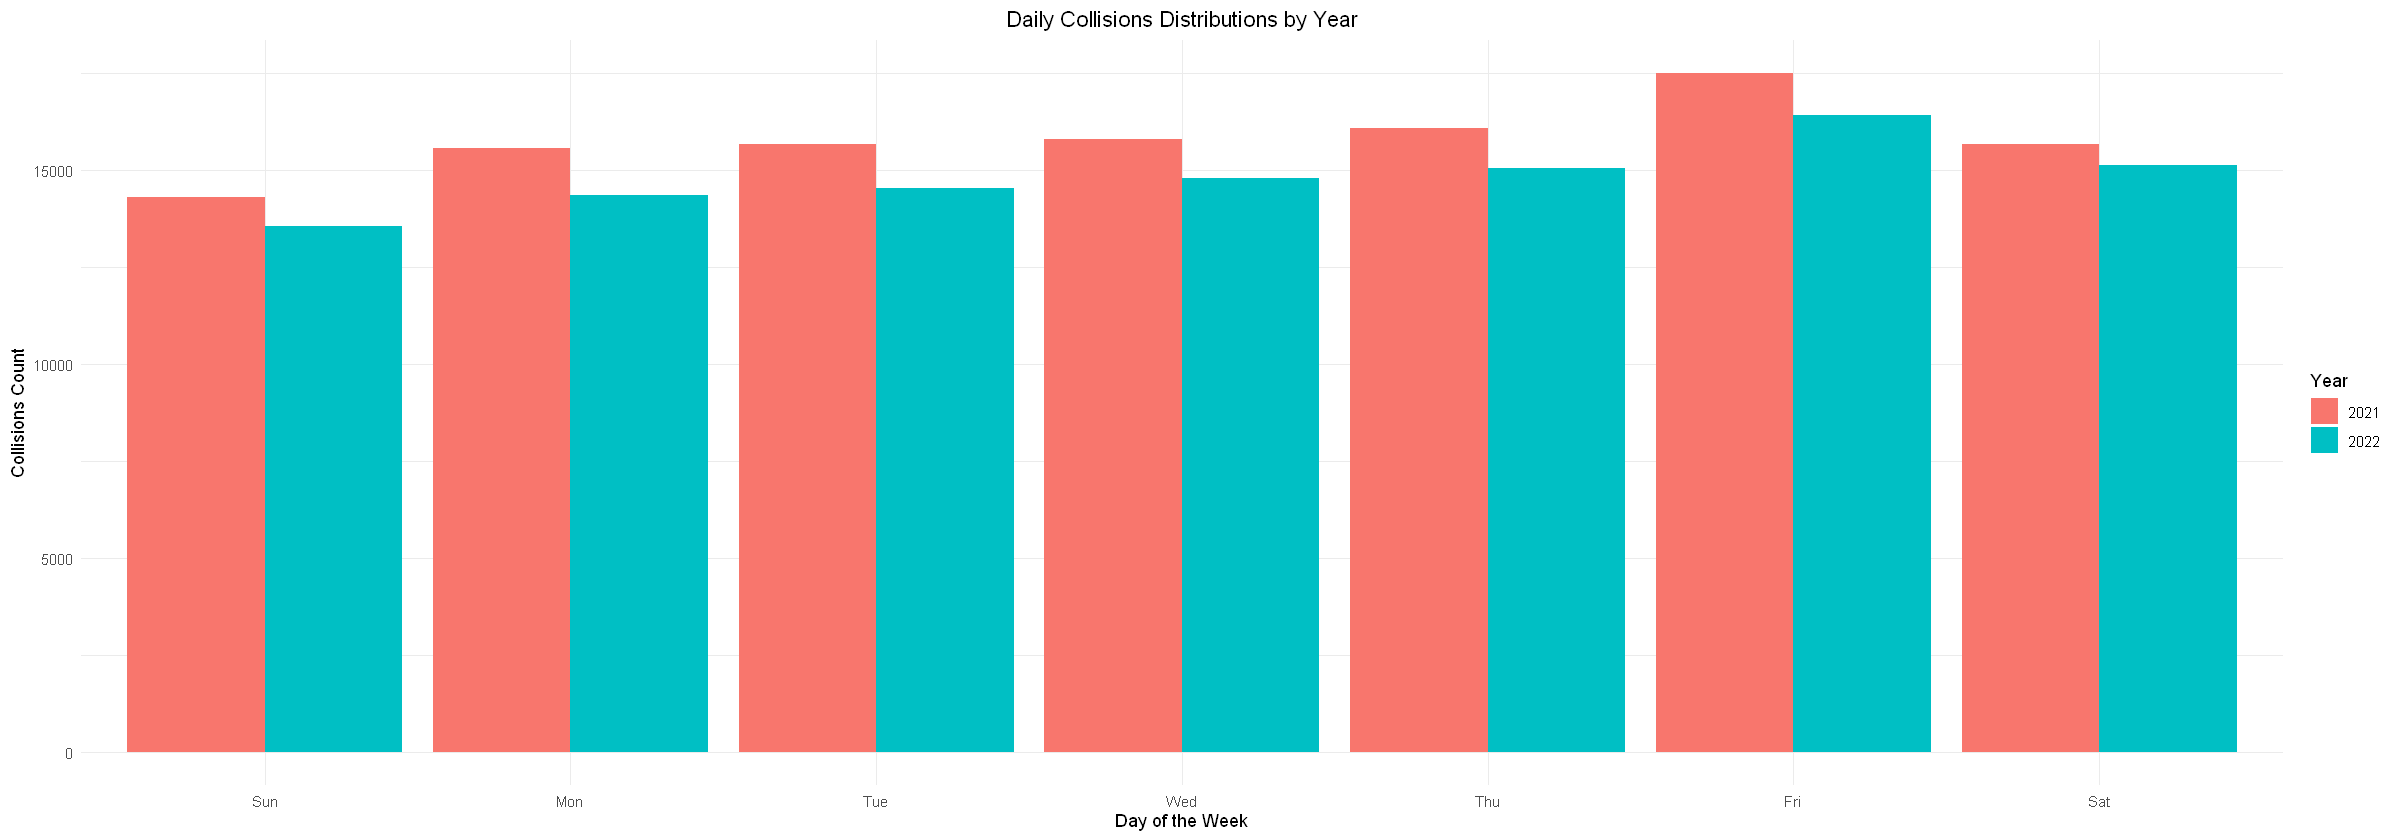

In [ ]:
#### Distribution of Daily Collisions #####

distribution_day = bind_rows(
  df_2021 |> count(Day_Of_Week) |> mutate(Year = 2021),
  df_2022 |> count(Day_Of_Week) |> mutate(Year = 2022)
)

ggplot(distribution_day, aes(x = Day_Of_Week, y = n, fill = as.factor(Year))) +
  geom_bar(stat = "identity", position = "dodge") +
  labs(title = "Daily Collisions Distributions by Year",
       x = "Day of the Week", 
       y = "Number of Collisions",
       fill = "Year") +
  theme_minimal() +
  theme(plot.title = element_text(hjust = 0.5))


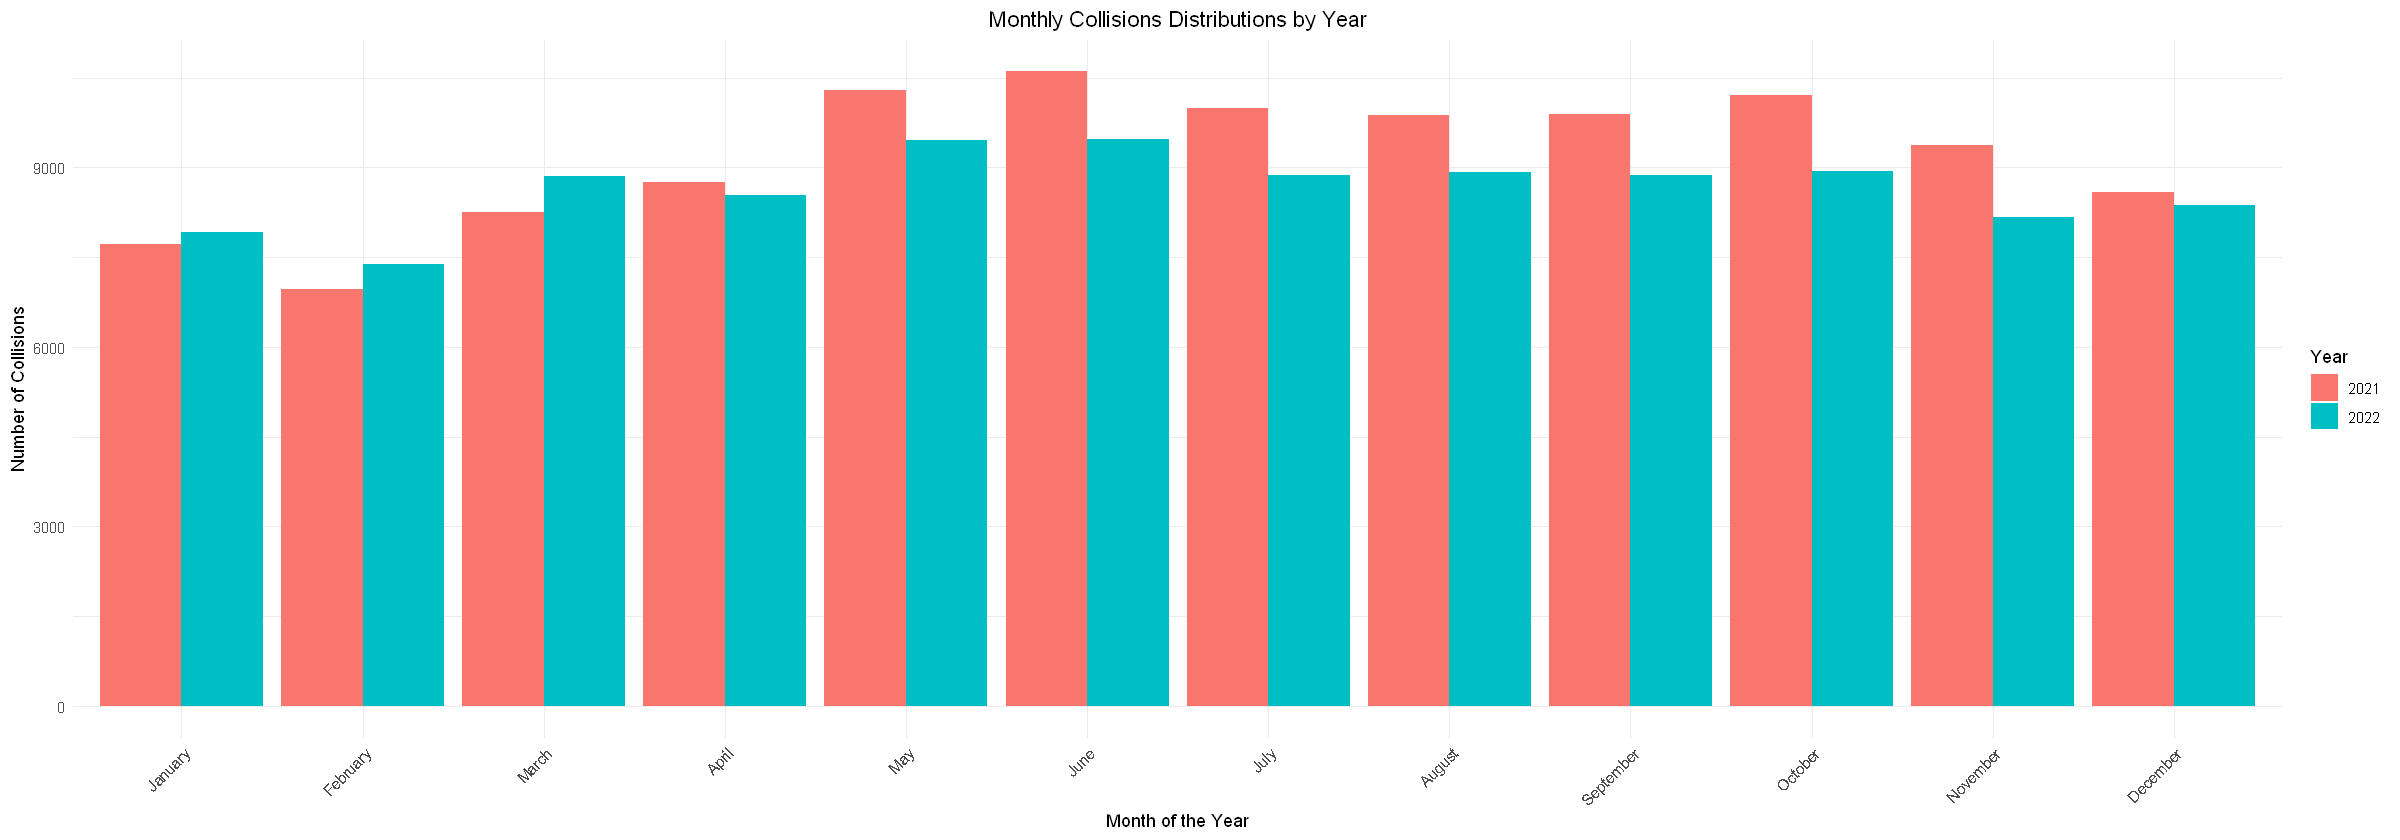

In [19]:
# Count the Monthly Collisions for 2021 and 2022
distribution_month = bind_rows(
     df_2021 |> count(Month) |> mutate(Year = 2021),
     df_2022 |> count(Month) |> mutate(Year = 2022)
)

ggplot(distribution_month, aes(x = Month, y = n, fill = as.factor(Year))) +
     geom_bar(stat = "identity", position = "dodge") +
     labs(title = "Monthly Collisions Distributions by Year",
                x = "Month of the Year",
                y = "Number of Collisions",
                fill = "Year") +
     theme_minimal() +
     theme(plot.title = element_text(hjust = 0.5),
                    axis.text.x = element_text(angle = 45, hjust = 1))

In [2]:
df

function (x, df1, df2, ncp, log = FALSE) 
{
    if (missing(ncp)) 
        .Call(C_df, x, df1, df2, log)
    else .Call(C_dnf, x, df1, df2, ncp, log)
}
<bytecode: 0x000001b132222a18>
<environment: namespace:stats>

In [ ]:
# Count the occurrences of each accident type
accident_type_distribution <- df |> count(Collision_Type)

# Plot the distribution of accident types
ggplot(accident_type_distribution, aes(x = reorder(Collision_Type, -n), y = n, fill = Collision_Type)) +
    geom_bar(stat = "identity") +
    labs(title = "Most Common Types of Accidents",
             x = "Type of Collision",
             y = "Number of Collisions") +
    theme_minimal() +
    theme(plot.title = element_text(hjust = 0.5),
                axis.text.x = element_text(angle = 45, hjust = 1)) +
    guides(fill = "none")

ERROR: [1m[33mError[39m in `count()`:[22m
[1m[22m[33m![39m Must group by variables found in `.data`.
[31m✖[39m Column `Collision_Type` is not found.


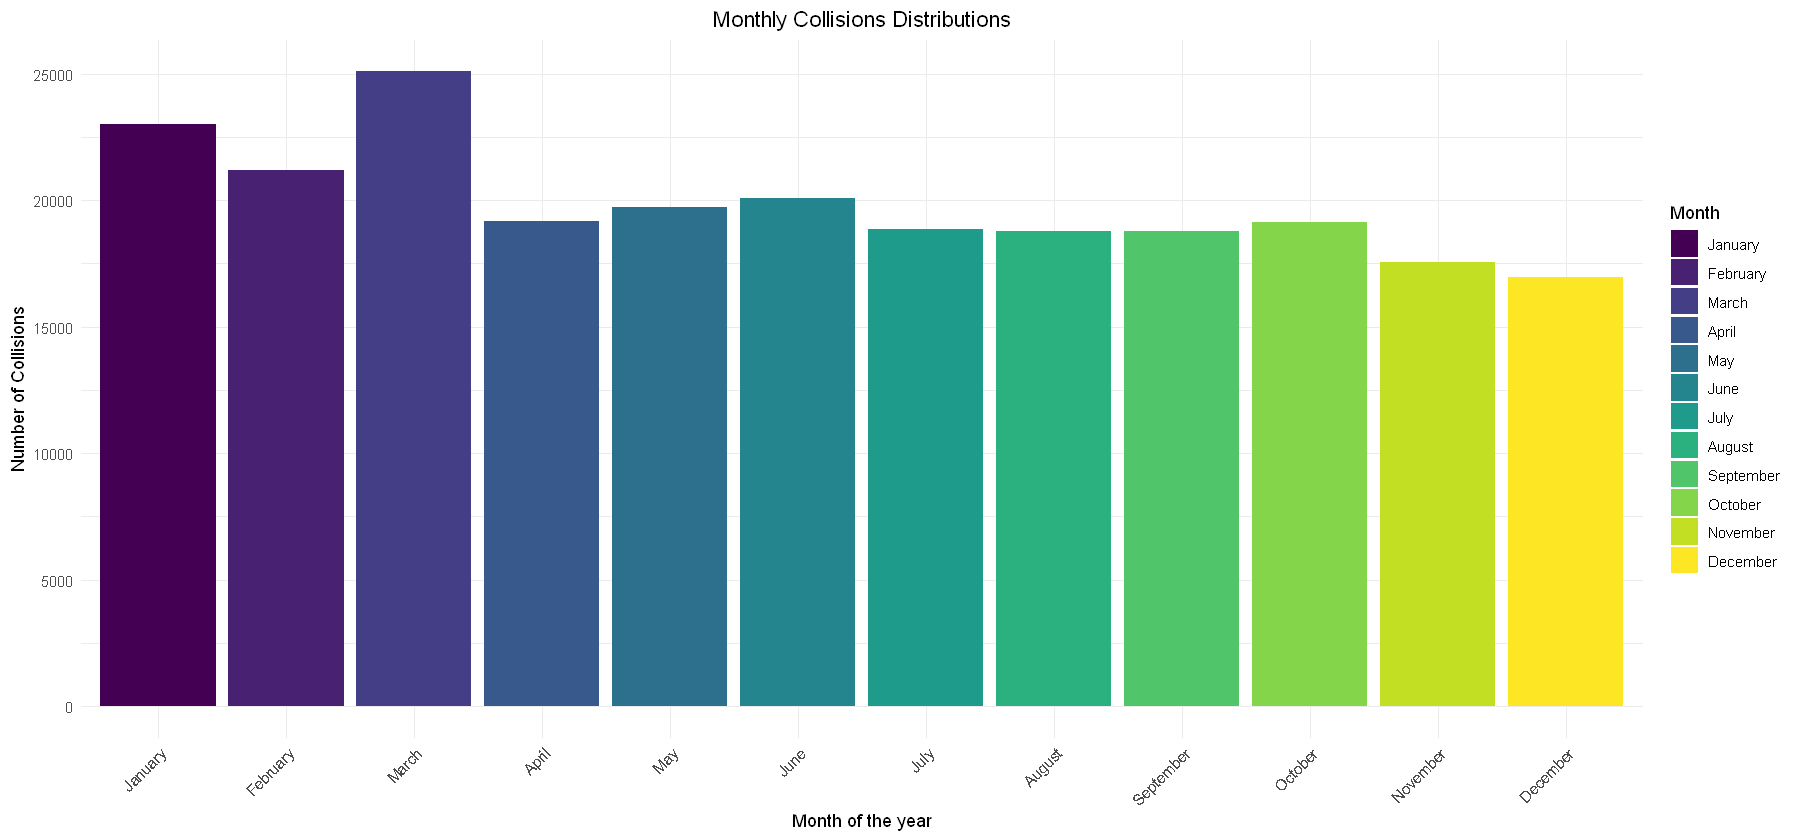

In [16]:
#### Distribution of Monthly Collisions #####

#Count the Monthly Collisions
distribution_month = df |> count(Month)

ggplot(distribution_month, aes(x = Month, y = n, fill = Month)) +
  geom_bar(stat = "identity") +
  labs(title = "Monthly Collisions Distributions",
       x = "Month of the year",
       y = "Number of Collisions") +
  theme_minimal() +
  theme(plot.title = element_text(hjust = 0.5),
        axis.text.x = element_text(angle = 45, hjust = 1))


In [9]:
# nyc_bbox <- c(left = -74.2591, bottom = 40.4774, right = -73.7004, top = 40.9176)

# # Download street data for NYC
# nyc_streets <- opq(bbox = nyc_bbox) %>%
#   add_osm_feature(key = "highway") %>%
#   osmdata_sf()

In [8]:
# # Extract the lines (streets) from the data
# nyc_streets_lines <- nyc_streets$osm_lines
# nyc_streets_lines

# # Plot the NYC streets
# tm_shape(nyc_streets_lines) +
#   tm_lines(col = "black", lwd = 0.5) +
#   tm_layout(main.title = "New York City Streets", 
#             main.title.size = 1.2,
#             bg.color = "white")

# # Install and load the tigris package
# install.packages("tigris")
# library(tigris)

# # Download NYC borough boundaries
# nyc_boroughs <- counties(state = "NY", cb = TRUE) %>%
#   filter(NAME %in% c("New York", "Kings", "Queens", "Bronx", "Richmond"))

# # Plot the map with borough boundaries
# tm_shape(nyc_streets_lines) +
#   tm_lines(col = "black", lwd = 0.5) +
#   tm_shape(nyc_boroughs) +
#   tm_borders(col = "red", lwd = 2) +
#   tm_layout(main.title = "New York City Streets with Borough Boundaries", 
#             main.title.size = 1.2,
#             bg.color = "white")
# # Install and load the tigris package
# install.packages("tigris")
# library(tigris)

# # Download NYC borough boundaries
# nyc_boroughs <- counties(state = "NY", cb = TRUE) %>%
#   filter(NAME %in% c("New York", "Kings", "Queens", "Bronx", "Richmond"))

# # Plot the map with borough boundaries
# tm_shape(nyc_streets_lines) +
#   tm_lines(col = "black", lwd = 0.5) +
#   tm_shape(nyc_boroughs) +
#   tm_borders(col = "red", lwd = 2) +
#   tm_layout(main.title = "New York City Streets with Borough Boundaries", 
#             main.title.size = 1.2,
#             bg.color = "white")